In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import pandas as pd
from os import listdir
from os.path import isfile, join, exists
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import seaborn as sns
from matplotlib.patches import Ellipse
import misc_functions as f
from misc_functions import player_dist
from misc_functions import draw_half_court

In [55]:
shots_fixed=pd.read_csv("data/shots/shots_fixed.csv")##This uses the 'build.lib.movement.fix_shot_times.py'-
##-module. Soon we will see it does not quite do it's job well enough
##Put the shots in chronological order for ease 
shots_fixed.sort_values('GAME_EVENT_ID',axis=0, ascending=True, inplace=True)
shots_fixed.reset_index(inplace=True,drop=True)

shots_fixed

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,EVENTTIME,QUARTER,SHOT_TIME
0,Shot Chart Detail,21500507,2,2449,Luis Scola,1610612761,Toronto Raptors,1,11,36,...,-229.0716,4.6616,1,1,20160103,TOR,CHI,696,1.0,699.41
1,Shot Chart Detail,21500502,2,201976,Patrick Beverley,1610612745,Houston Rockets,1,11,34,...,-122.8326,93.3816,1,0,20160102,SAS,HOU,694,1.0,662.77
2,Shot Chart Detail,21500438,4,201567,Kevin Love,1610612739,Cleveland Cavaliers,1,11,3,...,-47.9774,-3.6425,1,0,20151225,GSW,CLE,663,1.0,665.86
3,Shot Chart Detail,21500507,4,202685,Jonas Valanciunas,1610612761,Toronto Raptors,1,11,5,...,-42.3619,0.8178,1,0,20160103,TOR,CHI,665,1.0,698.09
4,Shot Chart Detail,21500502,4,201980,Danny Green,1610612759,San Antonio Spurs,1,11,16,...,-175.6979,137.4692,1,1,20160102,SAS,HOU,676,1.0,651.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,Shot Chart Detail,21500502,528,203613,Jonathon Simmons,1610612759,San Antonio Spurs,4,0,31,...,-23.9723,253.4432,1,1,20160102,SAS,HOU,31,4.0,6.56
477,Shot Chart Detail,21500502,529,1891,Jason Terry,1610612745,Houston Rockets,4,0,26,...,-23.9723,253.4432,1,1,20160102,SAS,HOU,26,4.0,6.56
478,Shot Chart Detail,21500507,534,201942,DeMar DeRozan,1610612761,Toronto Raptors,4,0,0,...,209.5429,156.8249,1,0,20160103,TOR,CHI,0,4.0,1.09
479,Shot Chart Detail,21500438,542,2544,LeBron James,1610612739,Cleveland Cavaliers,4,0,12,...,-115.5941,251.8576,1,0,20151225,GSW,CLE,12,4.0,15.95


In [56]:
##Show what manual data-fixing looks like for the warriors game
df=pd.read_csv('data/converted/0021500438_converted.csv')##Read in the tracking data
shots_fixed = shots_fixed.loc[shots_fixed.GAME_ID==21500438].reset_index(drop=True)##Isolating only this game
f.add_names(df)                                                          ##for presentation purposes

In [57]:
shots_fixed.iloc[1:4]##Events 6,8,10 have the same 'SHOT_TIME' val
print(shots_fixed.loc[shots_fixed['SHOT_TIME']==660.16][['GAME_EVENT_ID','PLAYER_NAME','PLAYER_ID','EVENTTIME','SHOT_TIME']])
##Going to create plots of distance between ball and player taking shot using the tracking data 
##to try and find correct 'SHOT_TIME' value and manually assign

   GAME_EVENT_ID    PLAYER_NAME  PLAYER_ID  EVENTTIME  SHOT_TIME
1              6  Klay Thompson     202691        658     660.16
2              8     Kevin Love     201567        643     660.16
3             10   Andrew Bogut     101106        629     660.16


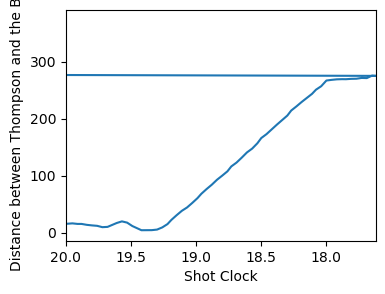

In [58]:
##Event_id 6 is probably the copy that's correct, but lets examine it to be sure
df0=df.loc[df['event_id']==6]
##Look around the 'EVENTTIME' value
df0=df0.loc[(df0['quarter']==1) & (df0['game_clock']<662) & (df0['game_clock']>654)]
##Player location during the interval of interest
player = df0[df0.player_id==202691]
##get the group that consists of only the ball
ball = df0[df0.player_id==-1]
##Get the distanced between the player and the ball during the interval
Thompson_ball_dist = player_dist(ball[["x_loc", "y_loc"]], player[["x_loc", "y_loc"]])

plt.figure(figsize=(4,3))

x = df0.shot_clock.unique()
y =  Thompson_ball_dist

plt.plot(x, y)
##Shot took place with ~19 second on shot clock
plt.xlim(20, min(x))

plt.xlabel("Shot Clock")
plt.ylabel("Distance between Thompson and the Ball")

plt.show()
##Here we visually see the increase in distance near 19 representing the player shooting the ball towards the hoop
##I don't know what the line at the top is but it's not important

In [59]:
##Looks like the shot takes place right near 19.5
##Look at the tracking to find a plausible moment the shot could've taken place
##Going to find the moment ball starts moving
print(df0.loc[(df0.shot_clock<20) & (df0.shot_clock>19) & (df0.player_id==-1)][['x_loc','y_loc','game_clock','shot_clock']])
##'SHOT_TIME' = 660.16 makes sense.

          x_loc     y_loc  game_clock  shot_clock
33264  145.0658  302.1944      660.64       19.99
33275  142.2495  300.4010      660.60       19.95
33286  141.6479  297.6647      660.56       19.91
33297  140.2345  294.7949      660.52       19.88
33308  140.2096  290.5314      660.48       19.84
33319  139.5748  285.0015      660.44       19.80
33330  138.8101  281.4112      660.40       19.76
33341  140.2214  274.6166      660.36       19.72
33352  141.2436  267.0346      660.32       19.68
33363  139.1902  261.2519      660.28       19.65
33374  137.1785  254.9460      660.24       19.61
33385  134.1067  250.6664      660.20       19.57
33396  134.4394  250.3789      660.16       19.53
33407  137.6837  252.5250      660.12       19.49
33418  139.5707  254.0653      660.08       19.45
33429  141.4222  254.6836      660.04       19.42
33440  141.2720  253.1632      660.00       19.38
33451  139.0339  252.2111      659.96       19.34
33462  137.8622  250.2985      659.92       19.30


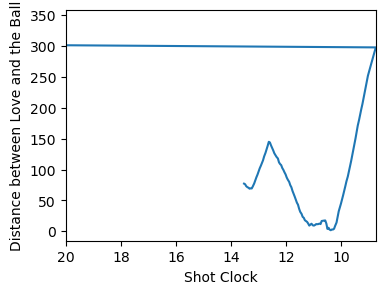

In [60]:
##Event_id 8
df1=df.loc[df['event_id']==8]
##Look around the 'EVENTTIME' value
df1=df1.loc[(df1['quarter']==1) & (df1['game_clock']<648) & (df1['game_clock']>638)]
##Player location during the interval of interest
player = df1[df1.player_id==201567]
##get the group that consists of only the ball
ball = df1[df1.player_id==-1]
##Get the distanced between the player and the ball during the interval
Love_ball_dist = player_dist(ball[["x_loc", "y_loc"]], player[["x_loc", "y_loc"]])

plt.figure(figsize=(4,3))

x = df1.shot_clock.unique()
y =  Love_ball_dist

plt.plot(x, y)
##Shot took place with ~10 second on shot clock
plt.xlim(20, min(x))

plt.xlabel("Shot Clock")
plt.ylabel("Distance between Love and the Ball")

plt.show()
##Here we visually see the spike near shot_clock=10 representing the player shooting the ball towards the hoop
##I don't know what the line at the top is but it's not important

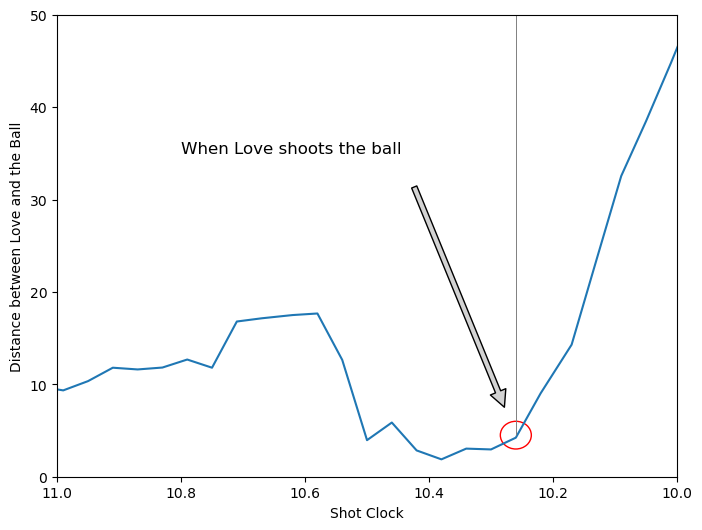

In [61]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

x = df1.shot_clock.unique()
y =  Love_ball_dist

plt.plot(x, y)
##Shot took place with ~10 second on shot clock
plt.xlim(11, 10)
plt.ylim(0,50)
plt.xlabel("Shot Clock")
plt.ylabel("Distance between Love and the Ball")
plt.vlines(10.26, 4.5, 300, color='gray', lw=0.7)
plt.annotate("When Love shoots the ball", (10.26, 4.5), 
             xytext=(10.8, 35), fontsize=12, 
             arrowprops=dict(facecolor='lightgray', shrink=0.10))

point=Ellipse((10.26,4.5),0.05,3,angle=0,color='red',fc='none')
ax.add_patch(point)

plt.show()


In [62]:
##Looks like the shot takes place right near 10.4
##Look at the tracking to find a plausible moment the shot could've taken place
##Going to find the moment ball starts moving
print(df1.loc[(df1.shot_clock<10.5) & (df1.shot_clock>10) & (df1.player_id==-1)][['x_loc','y_loc','game_clock','shot_clock']])
##Take 'SHOT_TIME' = 644.78
shots_fixed.loc[shots_fixed['GAME_EVENT_ID']==8,'SHOT_TIME'] =644.78
shots_fixed.loc[shots_fixed['GAME_EVENT_ID']==8]

          x_loc     y_loc  game_clock  shot_clock
42537 -207.2540  126.7512      644.98       10.46
42548 -205.2075  129.7111      644.94       10.42
42559 -205.7208  130.5891      644.90       10.38
42570 -205.2382  129.5573      644.86       10.34
42581 -204.8355  129.4518      644.82       10.30
42592 -203.9345  128.4579      644.78       10.26
42603 -199.9725  124.6279      644.74       10.22
42614 -195.8540  120.8347      644.70       10.17
42625 -186.9759  116.4621      644.66       10.13
42636 -178.0977  112.0894      644.62       10.09
42647 -172.4204  108.4855      644.58       10.05
42658 -166.5984  104.7754      644.55       10.01


,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,EVENTTIME,QUARTER,SHOT_TIME
2,Shot Chart Detail,21500438,8,201567,Kevin Love,1610612739,Cleveland Cavaliers,1,10,43,...,134.4394,250.3789,1,0,20151225,GSW,CLE,643,1.0,644.78


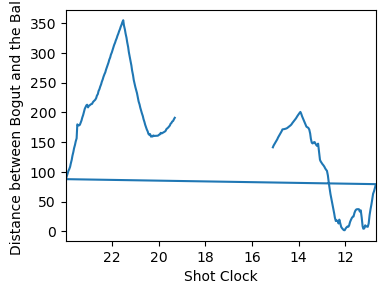

In [63]:
##Event_id 10
df2=df.loc[df['event_id']==10]
##Look around the 'EVENTTIME' value
df2=df2.loc[(df2['quarter']==1) & (df2['game_clock']<634) & (df2['game_clock']>624)]
##Player location during the interval of interest
player = df2[df2.player_id==101106]
##get the group that consists of only the ball
ball = df2[df2.player_id==-1]
##Get the distanced between the player and the ball during the interval
Bogut_ball_dist = player_dist(ball[["x_loc", "y_loc"]], player[["x_loc", "y_loc"]])

plt.figure(figsize=(4,3))

x = df2.shot_clock.unique()
y =  Bogut_ball_dist

plt.plot(x, y)
##Shot took place with ~12 second on shot clock
plt.xlim(max(x), min(x))

plt.xlabel("Shot Clock")
plt.ylabel("Distance between Bogut and the Ball")

plt.show()
##Here we visually see the spike near shot_clock=12, it's harder to see the spike because this is a dunk not a jumpshot
##I still don't know what the almost horizontal line is, but it still doesn't matter

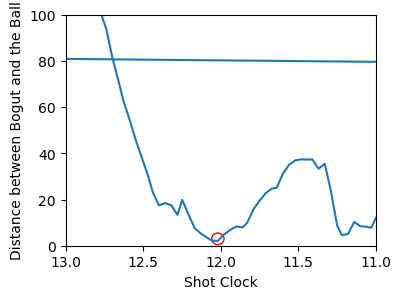

In [64]:

##Refine a little bit:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot()

x = df2.shot_clock.unique()
y =  Bogut_ball_dist

distance=plt.plot(x, y)
##Shot took place with ~12 second on shot clock
plt.xlim(13, 11)
plt.ylim(0,100)

plt.xlabel("Shot Clock")
plt.ylabel("Distance between Bogut and the Ball")
point=Ellipse((12.02,3),0.08,5,angle=0,color='red',fc='none')
ax.add_patch(point)

plt.show()
##Here we can see Bogut dunks the ball around 12 seconds on the shot clock
##the second spike is likely the result of bogut slamming the ball through the hoop and it bouncing against the floor
##Going to be looking for that last little spike up in red

In [65]:
##Since most of the movement on a dunk is vertical which the tracking doesn't measure there probaly won't be a huge jump
##Looks like the shot takes place right near 12
##Look at the tracking to find a plausible moment the shot could've taken place
##Going to find the moment ball starts moving
print(df2.loc[(df2.shot_clock<12.5) & (df2.shot_clock>11.5) & (df2.player_id==-1)][['x_loc','y_loc','game_clock','shot_clock']])
##Take 'SHOT_TIME' = 631.04
shots_fixed.loc[shots_fixed['GAME_EVENT_ID']==10,'SHOT_TIME'] =630.76 
shots_fixed.loc[shots_fixed['GAME_EVENT_ID']==10]

         x_loc    y_loc  game_clock  shot_clock
53757  16.6788  12.5132      631.24       12.47
53768  13.2646  17.7363      631.20       12.44
53779  14.0416  20.1500      631.16       12.40
53790  12.5258  16.5045      631.12       12.36
53801  12.3874  14.5904      631.08       12.32
53812  14.0979  16.0498      631.04       12.28
53823   5.7160  10.4153      631.00       12.25
53834   9.5749  12.7078      630.96       12.21
53845  13.4338  15.2234      630.92       12.17
53856  13.3136  15.6014      630.88       12.13
53867  13.0903  15.8361      630.84       12.09
53878  12.9701  15.9167      630.80       12.06
53889  13.2115  14.5055      630.76       12.02
53900  10.3240  11.2891      630.72       11.98
53911   8.1829   8.4210      630.68       11.94
53922   8.5616   4.9893      630.64       11.90
53933   6.9623   5.1774      630.60       11.86
53944   2.5131   6.4941      630.56       11.83
53955  -4.2629  10.0681      630.52       11.79
53966  -8.6958  10.0077      630.48     

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,EVENTTIME,QUARTER,SHOT_TIME
3,Shot Chart Detail,21500438,10,101106,Andrew Bogut,1610612744,Golden State Warriors,1,10,29,...,134.4394,250.3789,1,1,20151225,GSW,CLE,629,1.0,630.76


In [67]:
##This is essentially the method for cleaning up the data manually

In [68]:
##ALGORITHMIC DATA FIXING/DATA FIXING BY METHOD
##To fix all the duplicates we are going to have to obscure the data a little bit
##We are going to take 'EVENTTIME' and find the closest value ~ +/- 0.04 seconds that it correlates to in the
def fix_shot_times_edited (shots,tracking):
    for i in range(0,len(shots)):
        
        a = tracking.loc[tracking['quarter']==shots.at[i,'QUARTER']]
        times = a[['game_clock']]
        time_to_check=shots.at[i,'EVENTTIME']##The time on the scoreboard when the shot is taken
        d=times.assign(diff= lambda x: abs(x.game_clock-time_to_check))##Find the absolute diff between
        ##Assign the game_clock value w the minimun diff to 'SHOT_TIME'
        low=d.loc[d['diff']==min(d['diff'])].reset_index(drop=True)
        shots.at[i,'SHOT_TIME']=low.at[0,'game_clock']

fix_shot_times_edited(shots_fixed,df)##Time consusming process

In [69]:
##Another issue that arises is that there are duplicate values in the location columns of shots_fixed

shots_fixed.iloc[60:63][['LOC_X','LOC_Y']]

,LOC_X,LOC_Y
60,-119.5902,0.7613
61,-119.5902,0.7613
62,-119.5902,0.7613


In [70]:

##I am going to over-write these values with the x_loc and y_loc of the ball at the moment
def fix_shot_locations (shots,tracking): ##Needs to be run AFTER fixing shot times
    for i in range(0,len(shots)):
        
        a = tracking.loc[tracking['game_clock']==shots.at[i,'SHOT_TIME']]
        ball_x=a.loc[a['player_id']==-1].reset_index(drop=True).at[0,'x_loc']
        ball_y=a.loc[a['player_id']==-1].reset_index(drop=True).at[0,'y_loc']
        shots.at[i,'LOC_X']=ball_x
        shots.at[i,'LOC_Y']=ball_y
fix_shot_locations(shots_fixed,df)

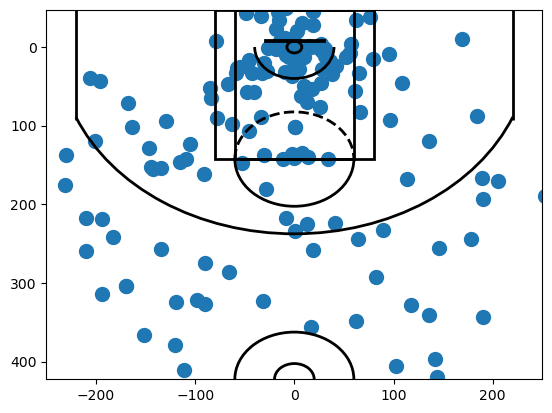

In [71]:
##Result of fixing shot locations

shot_loc=shots_fixed[['LOC_X','LOC_Y']]
plt.scatter(shot_loc.LOC_X,shot_loc.LOC_Y,s=100)
draw_half_court()
# Adjust plot limits to just fit in half court
plt.xlim(-250,250)
# Descending values along th y axis from bottom to top
# in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)

plt.show()
##Here we can really see the effects of the data fixing, compare to the shot-chart associated with the unfixed data below

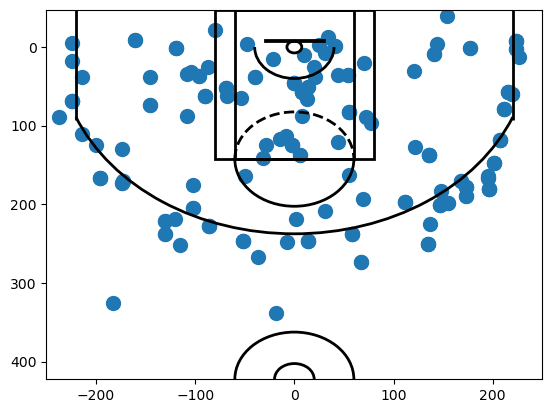

In [73]:
##Compare against the shot-chart of the un-fixed data
shots_fixed=pd.read_csv("data/shots/shots_fixed.csv")
shots_fixed=shots_fixed.loc[shots_fixed.GAME_ID==21500438]
shot_loc=shots_fixed[['LOC_X','LOC_Y']]
plt.scatter(shot_loc.LOC_X,shot_loc.LOC_Y,s=100)
draw_half_court()
# Adjust plot limits to just fit in half court
plt.xlim(-250,250)
# Descending values along th y axis from bottom to top
# in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)

plt.show()

In [75]:
##The affect of fixing over all the games:
shots_fixed=pd.read_csv("data/shots/shots_fixed.csv")
shots_fixed.sort_values('GAME_EVENT_ID',axis=0, ascending=True, inplace=True)
shots_fixed.reset_index(inplace=True,drop=True)
game1=pd.read_csv('data/converted/0021500438_converted.csv')##Read in the tracking data
shots_fixed1 = shots_fixed.loc[shots_fixed.GAME_ID==21500438].reset_index(drop=True)
game2=pd.read_csv('data/converted/0021500502_converted.csv')##Read in the tracking data
shots_fixed2 = shots_fixed.loc[shots_fixed.GAME_ID==21500502].reset_index(drop=True)
game3=pd.read_csv('data/converted/0021500507_converted.csv')##Read in the tracking data
shots_fixed3 = shots_fixed.loc[shots_fixed.GAME_ID==21500507].reset_index(drop=True)

fix_shot_times_edited(shots_fixed1,game1)
fix_shot_locations(shots_fixed1,game1)

fix_shot_times_edited(shots_fixed2,game2)
fix_shot_locations(shots_fixed2,game2)

fix_shot_times_edited(shots_fixed3,game3)
fix_shot_locations(shots_fixed3,game3)

shots_fixed = pd.concat([shots_fixed1,shots_fixed2,shots_fixed3])

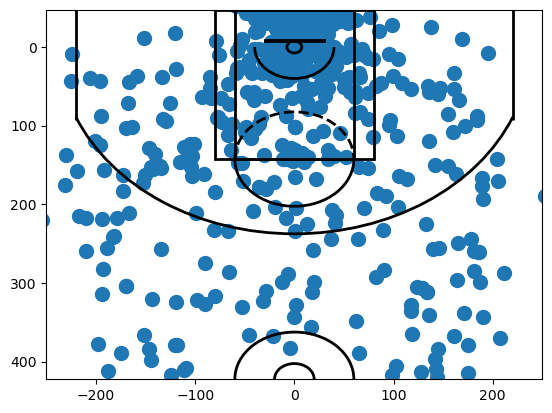

In [81]:
shot_loc=shots_fixed[['LOC_X','LOC_Y']]
plt.scatter(shot_loc.LOC_X,shot_loc.LOC_Y,s=100)
draw_half_court()
# Adjust plot limits to just fit in half court
plt.xlim(-250,250)
# Descending values along th y axis from bottom to top
# in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)

plt.show()
##Here we can really see the effects of the data fixing, compare to the shot-chart associated with the unfixed data below

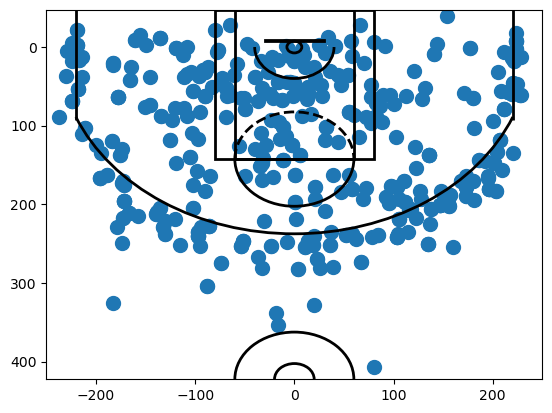

In [82]:
##Compare against the shot-chart of the un-fixed data
shots_fixed=pd.read_csv("data/shots/shots_fixed.csv")

shot_loc=shots_fixed[['LOC_X','LOC_Y']]
plt.scatter(shot_loc.LOC_X,shot_loc.LOC_Y,s=100)
draw_half_court()
# Adjust plot limits to just fit in half court
plt.xlim(-250,250)
# Descending values along th y axis from bottom to top
# in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)

plt.show()